In [2]:

from collections import defaultdict
from typing import Union, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

from artemis.interactions_methods.model_specific import ConditionalMinimalDepthMethod


In [3]:
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target
model = RandomForestRegressor(max_depth=6, max_features="sqrt", max_samples=0.8).fit(X, y)

In [3]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [3]:
base_estimator = model.base_estimator_
# sklearn.tree.DecisionTreeRegressor
# nie wiadomo, po co jest, nie działa

In [4]:
forest = model.estimators_
# list of `sklearn.tree.DecisionTreeRegressor`s

In [406]:
decision_tree = forest[5]
# sklearn.tree.DecisionTreeRegressor

In [407]:
decision_tree_object = decision_tree.tree_
# sklearn.tree._tree.Tree
# underlying tree object

In [408]:
tree_df = pd.DataFrame({
    "id": range(decision_tree_object.node_count),
    "left_child": decision_tree_object.children_left,
    "right_child": decision_tree_object.children_right,
    "split_variable": decision_tree_object.feature,
})

In [409]:
tree_df

,id,left_child,right_child,split_variable
0,0,1,64,2
1,1,2,33,0
2,2,3,18,7
3,3,4,11,2
4,4,5,8,1
...,...,...,...,...
120,120,121,124,2
121,121,122,123,5
122,122,-1,-1,-2
123,123,-1,-1,-2


In [376]:
def bfs(tree):
    current_lvl_ids = [0]
    next_lvl_ids = np.array([])
    depth = np.zeros(len(tree))
    current_depth = 0
    split_variable_to_node_id = defaultdict(lambda: np.ndarray(0).astype(int))
    while len(current_lvl_ids) > 0:

        depth[current_lvl_ids] = current_depth
        grouped_by_split_var = tree.loc[current_lvl_ids, ["id", "split_variable"]].groupby("split_variable")[
            "id"].apply(np.array)

        for split_var, ids in grouped_by_split_var.items():
            split_variable_to_node_id[split_var] = np.hstack((split_variable_to_node_id[split_var], ids))

        next_lvl_ids = np.hstack(
            (
                next_lvl_ids,
                tree.loc[current_lvl_ids, "left_child"],
                tree.loc[current_lvl_ids, "right_child"],
            )
        )
        current_lvl_ids = list(next_lvl_ids[next_lvl_ids >= 0].astype(int))
        next_lvl_ids = np.array([])
        current_depth += 1

    del split_variable_to_node_id[-2]
    return depth.astype(int), split_variable_to_node_id

In [377]:
depth, split = bfs(tree_df)

In [378]:
split

defaultdict(<function __main__.bfs.<locals>.<lambda>()>,
            {2: array([0, 3]),
             3: array([ 1, 16]),
             0: array([17, 24, 18, 25, 28]),
             6: array([ 2,  9,  6, 13]),
             1: array([21]),
             5: array([10])})

In [379]:
depth

array([0, 1, 2, 3, 4, 4, 3, 4, 4, 2, 3, 4, 4, 3, 4, 4, 1, 2, 3, 4, 4, 3,
       4, 4, 2, 3, 4, 4, 3, 4, 4])

In [385]:
result

,Root feature,Child feature,Value
0,2,2,2.0
1,2,3,0.0
2,2,0,1.0
3,2,6,1.0
4,2,1,2.0
5,2,5,2.0
6,3,2,1.0
7,3,3,None
8,3,0,0.0
9,3,6,0.0


In [386]:
result.pivot_table("Value", "Child feature", "Root feature")

Root feature,0,2,3,6
Child feature,,,,
0,0.0,1.0,0.0,NaN
1,0.0,2.0,1.0,NaN
2,NaN,2.0,1.0,0.0
3,NaN,0.0,NaN,NaN
5,NaN,2.0,1.0,0.0
6,NaN,1.0,0.0,0.0


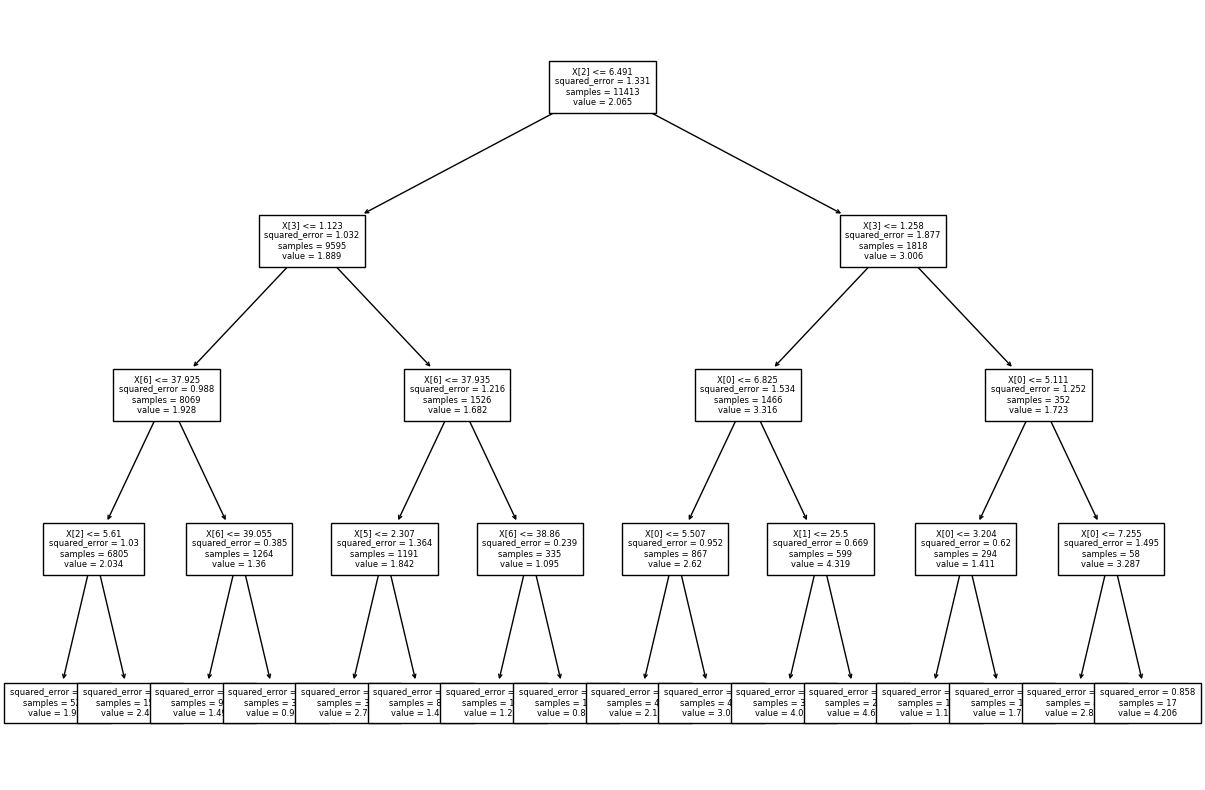

In [383]:
plt.figure(figsize=(15, 10))
sklearn.tree.plot_tree(decision_tree, fontsize=6)
plt.show()

In [244]:
def _get_node_depths(tree_object) -> pd.Series:
    current_lvl_ids = [0]
    next_lvl_ids = np.array([])
    depth = np.zeros(tree_object.node_count)
    current_lvl = 0
    while len(current_lvl_ids) > 0:
        depth[current_lvl_ids] = current_lvl
        next_lvl_ids = np.hstack(
            (
                next_lvl_ids,
                tree_object.children_left[current_lvl_ids],
                tree_object.children_right[current_lvl_ids],
            )
        )
        current_lvl_ids = list(next_lvl_ids[next_lvl_ids >= 0].astype(int))
        next_lvl_ids = np.array([])
        current_lvl += 1
    return depth.astype(int)


def _make_tree_df_representation(tree_object) -> pd.DataFrame:
    tree_df = pd.DataFrame(
        {
            "id": range(tree_object.node_count),
            "left_child": tree_object.children_left,
            "right_child": tree_object.children_right,
            "depth": _get_node_depths(tree_object),
            "split_variable": tree_object.feature,
            "threshold": tree_object.threshold,
        }
    )
    tree_df = (
        tree_df.sort_values(by=["depth", "id"]).loc[tree_df["split_variable"] != -2].reset_index(drop=True)
    )  # rows with -2 are leaves (no split variable)
    tree_df[list(range(tree_object.n_features))] = 0
    return tree_df


def _calculate_conditional_minimal_depth_one_tree(decision_tree, id: int) -> pd.DataFrame:
    tree_object = decision_tree.tree_
    tree_df = _make_tree_df_representation(tree_object)
    offset = np.where(tree_df.columns == 0)[0][0]
    maximal_subtrees_positions = dict(tree_df.groupby("split_variable").depth.idxmin())
    for i in maximal_subtrees_positions.keys():
        start = maximal_subtrees_positions[i]
        df = tree_df.iloc[
             start:,
             ]
        df.iloc[0, i + offset] = 0
        for k in range(1, len(df)):
            k_id = df.iloc[k, 0]
            subset = df.loc[
                (df["left_child"] == k_id) | (df["right_child"] == k_id),
            ]
            if len(subset) != 0 and subset.loc[:, i].values[0] is not None:
                df.iloc[k, i + offset] = (
                        df.loc[(df["left_child"] == k_id) | (df["right_child"] == k_id)][i].values[0] + 1
                )
        if start == 0:
            return df
        tree_df.iloc[start:, i + offset:] = df.iloc[:, i + offset:]

    # return tree_df
    tree_df.iloc[:, offset:] = tree_df.iloc[:, offset:].replace({0: None})
    tree_result = tree_df.groupby("split_variable").min().iloc[:, offset - 1:] - 1
    return tree_result
    tree_result = tree_result.reset_index()
    tree_result.insert(0, "tree_id", id)
    return tree_result


In [142]:
mati = _calculate_conditional_minimal_depth_one_tree(decision_tree, 1)

In [245]:
mati_test = _calculate_conditional_minimal_depth_one_tree(decision_tree, 1)

In [263]:
mati_test.loc[mati_test["split_variable"] == 0]


,id,left_child,right_child,depth,split_variable,threshold,0,1,2,3,4,5,6,7
5,65,66,81,2,0,6.83105,0,0,0,0,0,0,0,0
9,34,35,42,3,0,3.62740,0,0,0,0,0,0,0,0
10,49,50,57,3,0,3.44450,0,0,0,0,0,0,0,0
11,66,67,74,3,0,5.60280,0,0,0,0,0,0,0,0
13,97,98,105,3,0,4.23610,0,0,0,0,0,0,0,0
16,11,12,15,4,0,3.19025,0,0,0,0,0,0,0,0
35,20,21,22,5,0,2.83775,0,0,0,0,0,0,0,0
36,23,24,25,5,0,3.20235,0,0,0,0,0,0,0,0
37,27,28,29,5,0,4.79930,0,0,0,0,0,0,0,0
38,30,31,32,5,0,4.82650,0,0,0,0,0,0,0,0


In [262]:
mati_test.loc[mati_test["split_variable"] == 2]

,id,left_child,right_child,depth,split_variable,threshold,0,1,2,3,4,5,6,7
0,0,1,64,0,2,6.378688,0,0,0,0,0,0,0,0
8,18,19,26,3,2,5.763682,0,0,0,0,0,0,0,0
26,89,90,93,4,2,7.844265,0,0,0,0,0,0,0,0
29,113,114,117,4,2,57.330357,0,0,0,0,0,0,0,0
32,8,9,10,5,2,5.471498,0,0,0,0,0,0,0,0
48,71,72,73,5,2,9.442294,0,0,0,0,0,0,0,0
56,102,103,104,5,2,7.753909,0,0,0,0,0,0,0,0


In [249]:
# help(sklearn.tree._tree.Tree)
# node_count 
# capacity 
# max_depth 
# children_left -- list of left children IDs (s.t. X[:, feature[i]] <= threshold[i])
# children_right -- analogous
# feature -- to split on
# threshold
# value -- prediction on node
# impurity -- value of splitting criterion
# n_node_samples -- number of training samples in node

In [250]:
def get_depths(tree_object):
    current_lvl_ids = [0]
    next_lvl_ids = np.array([])
    depth = np.zeros(decision_tree_object.node_count)
    current_lvl = 0
    while (len(current_lvl_ids) > 0):
        depth[current_lvl_ids] = current_lvl
        next_lvl_ids = np.hstack((next_lvl_ids,
                                  decision_tree_object.children_left[current_lvl_ids],
                                  decision_tree_object.children_right[current_lvl_ids]))
        current_lvl_ids = list(next_lvl_ids[next_lvl_ids >= 0].astype(int))
        next_lvl_ids = np.array([])
        current_lvl += 1
    return depth.astype(int)

In [251]:
tree_df = pd.DataFrame({
    "id": range(decision_tree_object.node_count),
    "left_child": decision_tree_object.children_left,
    "right_child": decision_tree_object.children_right,
    "depth": get_depths(decision_tree_object),
    "split_variable": decision_tree_object.feature,
    "threshold": decision_tree_object.threshold,
    #"status": (decision_tree_object.children_left >= 0).astype(int), #split node = 1, leaf = 0
    "prediction": decision_tree_object.value.flatten()  # dla regresji
})

In [252]:
tree_df = tree_df.sort_values(by=["depth", "id"]).loc[tree_df["split_variable"] != -2].reset_index(drop=True)
tree_df

,id,left_child,right_child,depth,split_variable,threshold,prediction
0,0,1,64,0,0,5.578800,2.057422
1,1,2,33,1,0,3.198600,1.792455
2,64,65,96,1,0,7.814100,3.636324
3,2,3,18,2,5,2.161098,1.381799
4,33,34,49,2,5,2.326412,2.188594
...,...,...,...,...,...,...,...
58,109,110,111,5,6,33.300001,4.101505
59,114,115,116,5,2,6.507936,3.155000
60,117,118,119,5,4,39.000000,1.906250
61,121,122,123,5,7,-117.064999,4.927902


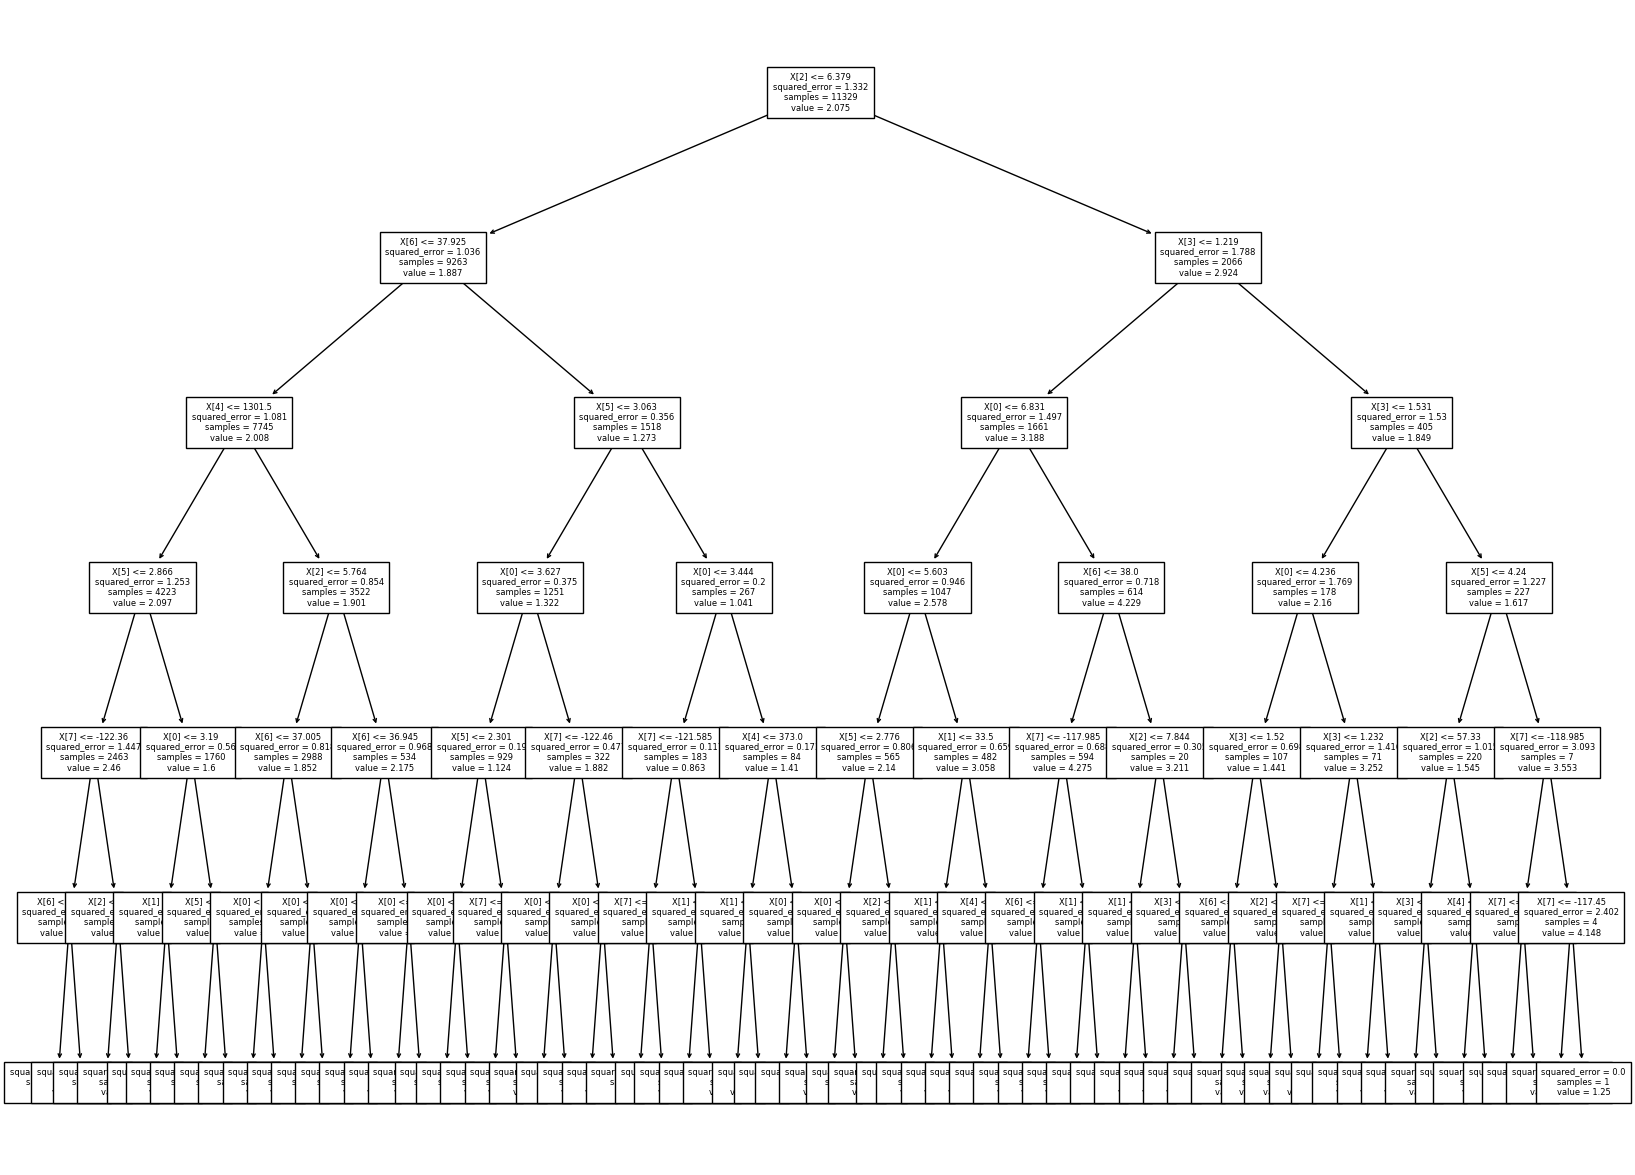

In [353]:
plt.figure(figsize=(20, 15))
sklearn.tree.plot_tree(decision_tree, fontsize=6)
plt.show()

In [107]:
maximal_subtrees_positions = dict(tree_df.groupby("split_variable").depth.idxmin())

In [108]:
maximal_subtrees_positions

{0: 0, 1: 9, 2: 3, 4: 14, 5: 4}

In [109]:
columns_dict = dict(zip(X.columns.to_list(), range(len(X.columns))))

In [110]:
tree_df[list(range(len(X.columns)))] = 0

In [111]:
offset = np.where(tree_df.columns == 0)[0][0]
for i in maximal_subtrees_positions.keys():
    start = maximal_subtrees_positions[i]
    df = tree_df.iloc[start:, ]
    df.iloc[0, i + offset] = 0
    for k in range(1, len(df)):
        k_id = df.iloc[k, 0]
        subset = df.loc[(df["left_child"] == k_id) | (df["right_child"] == k_id),]
        if len(subset) != 0:
            if subset.loc[:, i].values[0] is not None:
                df.iloc[k, i + offset] = df.loc[(df["left_child"] == k_id) | (df["right_child"] == k_id)][i].values[
                                             0] + 1
    tree_df.iloc[start:, i + offset:] = df.iloc[:, i + offset:]
tree_df.iloc[:, offset:] = tree_df.iloc[:, offset:].replace(0, None)

In [4]:
cond = ConditionalMinimalDepthMethod()

In [5]:
cond.fit(model, X, True)

100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


In [6]:
cond.variable_importance

,Feature,Value
0,MedInc,4.850000
1,Latitude,4.370000
2,AveRooms,4.140000
3,AveOccup,3.920000
4,Longitude,3.890000
5,HouseAge,3.767677
6,AveBedrms,3.122449
7,Population,2.422680


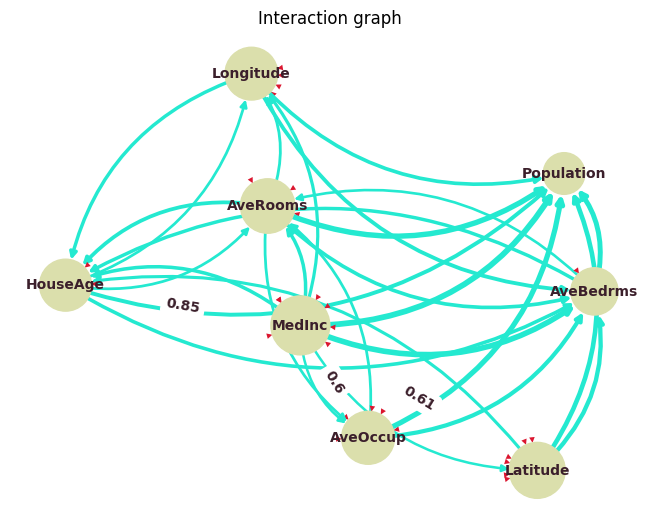

In [9]:
cond.plot("interaction graph")

In [14]:
cond.variable_importance["Feature"] if cond.variable_importance is not None else None

0        MedInc
1      AveRooms
2      Latitude
3      AveOccup
4     Longitude
5      HouseAge
6     AveBedrms
7    Population
Name: Feature, dtype: object

In [12]:
[69 * val / max(cond.variable_importance["Value"]) for val in
                       cond.variable_importance["Value"]] if cond.variable_importance is not None else 69

[69.0,
 60.966735966735975,
 60.966735966735975,
 57.380457380457386,
 57.380457380457386,
 51.35550935550936,
 43.60914760914761,
 35.35563535563536]